# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [19]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [20]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', error_bad_lines=False)

In [21]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [22]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [23]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [24]:
azdias.shape

(891221, 85)

In [25]:
feat_info.shape

(85, 4)

In [26]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [27]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,WOHNDAUER_2008,person,ordinal,[-1]
freq,1,43,49,26


In [28]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [29]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [30]:
azdias.isna().values.any()

True

In [31]:
null_col_count = azdias.isnull().sum()

In [32]:
azdias.isnull().sum().sum()

4896838

In [33]:
# Identify missing or unknown data values and convert them to NaNs.
for row in range(len(feat_info)):
    missing_value = feat_info.iloc[row]['missing_or_unknown']
    missing_value = missing_value[1:-1].split(",")
    missing_value = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_value]
    if missing_value != ['']:
        azdias = azdias.replace({feat_info.iloc[row]['attribute']: missing_value}, np.nan)

In [34]:
azdias.isnull().sum().sum()

8373929

In [15]:

'''
list_missing_value = []
for missing_value in feat_info['missing_or_unknown']:
    #print(missing_value[1:-1].split(","))
    #print(missing_value[1:-1])
    list_missing_value.append(missing_value[1:-1].split(","))
    
    '''
   

In [35]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [36]:
#type(null_col_count)
updated_null_count = azdias.isnull().sum()
s1 = pd.Series(null_col_count,name='As Is NaN')
s2 = pd.Series(updated_null_count,name='Updated NaN')
s = pd.concat([s1, s2], axis=1)
s

,As Is NaN,Updated NaN
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [38]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_percent = azdias.isnull().sum()*100/azdias.shape[0]
null_percent.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

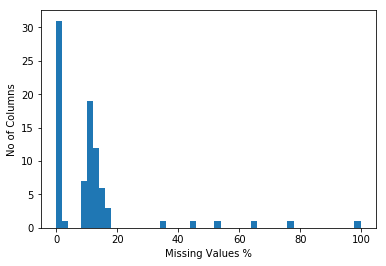

In [39]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(null_percent, bins=50)
plt.ylabel('No of Columns')
plt.xlabel('Missing Values %')
plt.show()


In [40]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
cols_to_remove = null_percent[(null_percent > 20)]
#cols_to_remove.index
azdias = azdias.drop(cols_to_remove.index, axis=1)
print("Columns to be removed are ", cols_to_remove.index)
print("After removing columns greater than 20% missing values the shape of the dataset is ",azdias.shape)

Columns to be removed are  Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
After removing columns greater than 20% missing values the shape of the dataset is  (891221, 79)


In [41]:
#Removing features from feat_info
feat_info['Flag'] = feat_info['attribute'].isin (cols_to_remove.index) 


#feat_info = feat_info.drop (feat_info[feat_info['Flag']==True].index)
feat_info.head(20)

,attribute,information_level,type,missing_or_unknown,Flag
0,AGER_TYP,person,categorical,"[-1,0]",True
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",False
2,ANREDE_KZ,person,categorical,"[-1,0]",False
3,CJT_GESAMTTYP,person,categorical,[0],False
4,FINANZ_MINIMALIST,person,ordinal,[-1],False
5,FINANZ_SPARER,person,ordinal,[-1],False
6,FINANZ_VORSORGER,person,ordinal,[-1],False
7,FINANZ_ANLEGER,person,ordinal,[-1],False
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],False
9,FINANZ_HAUSBAUER,person,ordinal,[-1],False


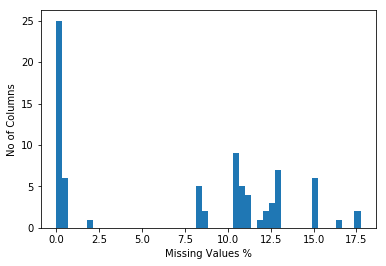

In [42]:
null_percent = null_percent.drop(cols_to_remove.index, axis=0)
plt.hist(null_percent, bins=50)
plt.ylabel('No of Columns')
plt.xlabel('Missing Values %')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

- Are there any patterns in missing values?  
Out of 85 columns, around 6 columns are having greater than 20% of missing values. Hence, they are outliers.



- Which columns were removed from the dataset?  
'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [43]:
# How much data is missing in each row of the dataset?
row_missing_percent = azdias.apply(lambda x: x.isnull().sum(), axis=1)

In [44]:
row_missing_percent = row_missing_percent.sort_values(ascending=False)
row_missing_percent.head(n=15)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
dtype: int64

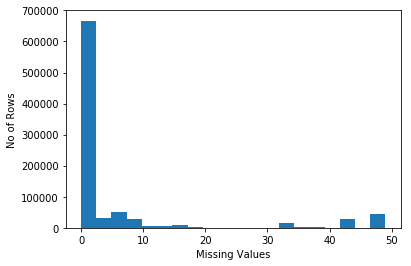

In [45]:

plt.hist(row_missing_percent, bins=20)
plt.ylabel('No of Rows')
plt.xlabel('Missing Values')
plt.show()

In [46]:
azdias_df = pd.concat([azdias, row_missing_percent], axis=1)


In [47]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_less_missing = azdias_df[azdias_df[0] <= 20]
azdias_more_missing = azdias_df[azdias_df[0] > 20]


In [48]:
azdias_less_missing['HH_EINKOMMEN_SCORE'].unique()

array([ 6.,  4.,  1.,  5.,  3.,  2.])

In [55]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_dist (df1, df2, column):
    fig, ax =plt.subplots(1,2)
    fig.set_figwidth(12)
    ax[0].set_title('Rows with less than 20 missing values')
    sns.countplot(df1[column], ax=ax[0])
    ax[1].set_title('Rows with greater than 20 missing values')
    sns.countplot(df2[column], ax=ax[1])
    fig.show()
    return


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


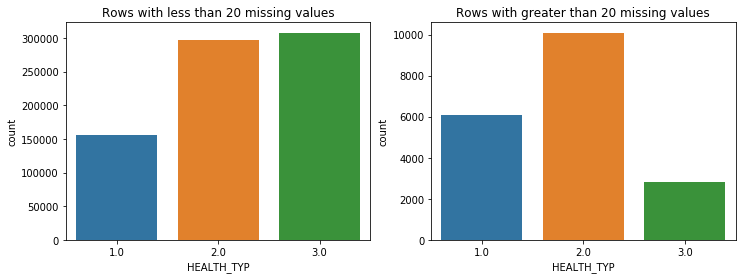

In [56]:
compare_dist (azdias_less_missing, azdias_more_missing, 'HEALTH_TYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


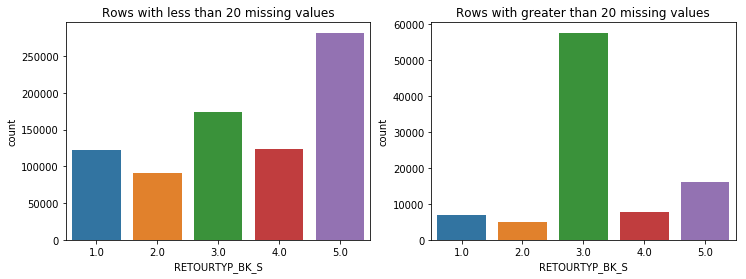

In [57]:
compare_dist (azdias_less_missing, azdias_more_missing, 'RETOURTYP_BK_S')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


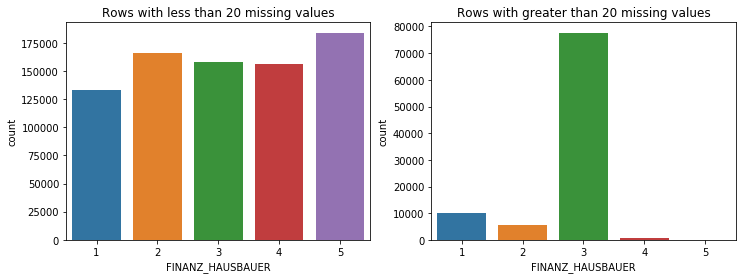

In [58]:
compare_dist (azdias_less_missing, azdias_more_missing, 'FINANZ_HAUSBAUER')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


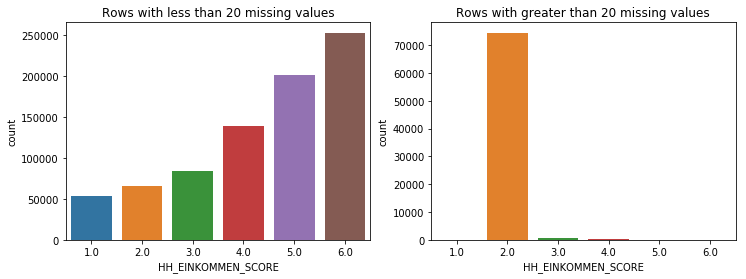

In [59]:
compare_dist (azdias_less_missing, azdias_more_missing, 'HH_EINKOMMEN_SCORE')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


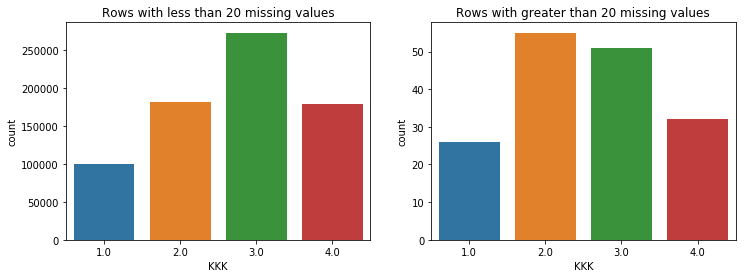

In [60]:
compare_dist (azdias_less_missing, azdias_more_missing, 'KKK')

#### Discussion 1.1.3: Assess Missing Data in Each Row
- Are the data with lots of missing values are qualitatively different from data with few or no missing values?  
I have chosen randomly few columns to compare the distribution for missing row less than 20 and missing row greater than 20. KKK (Purchasing power in region) column has around 17% missing data. From the chart itself there is not much significant difference between the distribution. HH_EINKOMMEN_SCORE (Estimated household net income), FINANZ_HAUSBAUER (home ownership) and RETOURTYP_BK_S (Return type) columns have very minimal missing value. For the chart it can be seen that the distributions between different missing row are significantly different. Therefore, removing the missing rows from the dataset during analysis can have an effect. HEALTH_TYP (Health typology) has around 12% missing data and it doesn't show much difference between the two distributions.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [61]:
# How many features are there of each data type?
feat_info.type.value_counts ()



ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [62]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info_subset = feat_info.drop (feat_info[feat_info['Flag']==True].index)
categories = feat_info_subset[feat_info_subset["type"]=="categorical"]['attribute']


In [63]:
# Re-encode categorical variable(s) to be kept in the analysis.

binary=[]
multi_level=[]

for i in categories:
    if azdias_less_missing[i].nunique()==2:
        binary.append(i)
    else:
        multi_level.append(i)

In [64]:
print("Binary features", binary)
print("Multi level features", multi_level)

Binary features ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi level features ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [66]:
for i in binary:
    print("Feature name- ", i, azdias_less_missing[i].unique())

Feature name-  ANREDE_KZ [2 1]
Feature name-  GREEN_AVANTGARDE [0 1]
Feature name-  SOHO_KZ [ 1.  0.]
Feature name-  VERS_TYP [  2.   1.  nan]
Feature name-  OST_WEST_KZ ['W' 'O']


In [67]:
azdias_less_missing['OST_WEST_KZ'] = azdias_less_missing['OST_WEST_KZ'].replace({'W':0,'O':1})
azdias_less_missing['OST_WEST_KZ'].unique()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([0, 1])

In [68]:
for i in multi_level:
    print("Feature name- ", i, azdias_less_missing[i].unique())

Feature name-  CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan]
Feature name-  FINANZTYP [1 6 5 2 4 3]
Feature name-  GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Feature name-  LP_FAMILIE_FEIN [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
Feature name-  LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.]
Feature name-  LP_STATUS_FEIN [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
Feature name-  LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
Feature name-  NATIONALITAET_KZ [  1.   3.   2.  nan]
Feature name-  SHOPPER_TYP [  3.   2.   1.   0.  nan]
Feature name-  ZABEOTYP [5 3 4 1 6 2]
Feature name-  GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.]
Feature name-  CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
Feature name-  CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B'

In [69]:
df_null = pd.DataFrame(null_percent, columns=['Null_%'])
df_null.reset_index(inplace=True)
df_null.head()

,index,Null_%
0,ALTERSKATEGORIE_GROB,0.323264
1,ANREDE_KZ,0.000000
2,CJT_GESAMTTYP,0.544646
3,FINANZ_MINIMALIST,0.000000
4,FINANZ_SPARER,0.000000


In [70]:
df_null['Flag'] = df_null['index'].isin (multi_level) 


In [71]:
df_null[df_null['Flag']==True].sort_values('Null_%', ascending=False)

,index,Null_%,Flag
36,SHOPPER_TYP,12.476816,True
19,NATIONALITAET_KZ,12.153551,True
52,CAMEO_DEUG_2015,11.147852,True
53,CAMEO_DEU_2015,11.147852,True
47,GEBAEUDETYP,10.451729,True
15,LP_FAMILIE_FEIN,8.728699,True
16,LP_FAMILIE_GROB,8.728699,True
2,CJT_GESAMTTYP,0.544646,True
10,GFK_URLAUBERTYP,0.544646,True
17,LP_STATUS_FEIN,0.544646,True


In [72]:
df_null_t = df_null[(df_null['Flag']==True)]
df_null_t['Flag'].unique()

array([ True], dtype=bool)

In [73]:
remove_multi_col = df_null_t[(df_null_t['Null_%']>8)]['index']
remove_multi_col

15     LP_FAMILIE_FEIN
16     LP_FAMILIE_GROB
19    NATIONALITAET_KZ
36         SHOPPER_TYP
47         GEBAEUDETYP
52     CAMEO_DEUG_2015
53      CAMEO_DEU_2015
Name: index, dtype: object

In [74]:
azdias_less_missing = azdias_less_missing.drop(remove_multi_col, axis=1)
azdias_less_missing.shape

(797426, 73)

In [75]:
d = pd.get_dummies(azdias_less_missing['CJT_GESAMTTYP'],prefix=['CJT_GESAMTTYP'])
azdias_less_missing = pd.concat([azdias_less_missing,d], axis=1)
azdias_less_missing = azdias_less_missing.drop('CJT_GESAMTTYP', axis=1)
azdias_less_missing.columns

Index([ 'ALTERSKATEGORIE_GROB',             'ANREDE_KZ',
           'FINANZ_MINIMALIST',         'FINANZ_SPARER',
            'FINANZ_VORSORGER',        'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER',      'FINANZ_HAUSBAUER',
                   'FINANZTYP',       'GFK_URLAUBERTYP',
            'GREEN_AVANTGARDE',            'HEALTH_TYP',
         'LP_LEBENSPHASE_FEIN',   'LP_LEBENSPHASE_GROB',
              'LP_STATUS_FEIN',        'LP_STATUS_GROB',
       'PRAEGENDE_JUGENDJAHRE',        'RETOURTYP_BK_S',
                   'SEMIO_SOZ',             'SEMIO_FAM',
                   'SEMIO_REL',             'SEMIO_MAT',
                  'SEMIO_VERT',            'SEMIO_LUST',
                   'SEMIO_ERL',            'SEMIO_KULT',
                   'SEMIO_RAT',            'SEMIO_KRIT',
                   'SEMIO_DOM',            'SEMIO_KAEM',
               'SEMIO_PFLICHT',           'SEMIO_TRADV',
                     'SOHO_KZ',              'VERS_TYP',
                    'ZABEOTYP',

In [76]:
d = pd.get_dummies(azdias_less_missing['GFK_URLAUBERTYP'],prefix=['GFK_URLAUBERTYP'])
azdias_less_missing = pd.concat([azdias_less_missing,d], axis=1)
azdias_less_missing = azdias_less_missing.drop('GFK_URLAUBERTYP', axis=1)
azdias_less_missing.columns

Index([    'ALTERSKATEGORIE_GROB',                'ANREDE_KZ',
              'FINANZ_MINIMALIST',            'FINANZ_SPARER',
               'FINANZ_VORSORGER',           'FINANZ_ANLEGER',
          'FINANZ_UNAUFFAELLIGER',         'FINANZ_HAUSBAUER',
                      'FINANZTYP',         'GREEN_AVANTGARDE',
                     'HEALTH_TYP',      'LP_LEBENSPHASE_FEIN',
            'LP_LEBENSPHASE_GROB',           'LP_STATUS_FEIN',
                 'LP_STATUS_GROB',    'PRAEGENDE_JUGENDJAHRE',
                 'RETOURTYP_BK_S',                'SEMIO_SOZ',
                      'SEMIO_FAM',                'SEMIO_REL',
                      'SEMIO_MAT',               'SEMIO_VERT',
                     'SEMIO_LUST',                'SEMIO_ERL',
                     'SEMIO_KULT',                'SEMIO_RAT',
                     'SEMIO_KRIT',                'SEMIO_DOM',
                     'SEMIO_KAEM',            'SEMIO_PFLICHT',
                    'SEMIO_TRADV',                  'SO

In [77]:
d = pd.get_dummies(azdias_less_missing['LP_STATUS_FEIN'], prefix=['LP_STATUS_FEIN'])
azdias_less_missing = pd.concat([azdias_less_missing,d], axis=1)
azdias_less_missing = azdias_less_missing.drop('LP_STATUS_FEIN', axis=1)
azdias_less_missing.columns

Index([    'ALTERSKATEGORIE_GROB',                'ANREDE_KZ',
              'FINANZ_MINIMALIST',            'FINANZ_SPARER',
               'FINANZ_VORSORGER',           'FINANZ_ANLEGER',
          'FINANZ_UNAUFFAELLIGER',         'FINANZ_HAUSBAUER',
                      'FINANZTYP',         'GREEN_AVANTGARDE',
                     'HEALTH_TYP',      'LP_LEBENSPHASE_FEIN',
            'LP_LEBENSPHASE_GROB',           'LP_STATUS_GROB',
          'PRAEGENDE_JUGENDJAHRE',           'RETOURTYP_BK_S',
                      'SEMIO_SOZ',                'SEMIO_FAM',
                      'SEMIO_REL',                'SEMIO_MAT',
                     'SEMIO_VERT',               'SEMIO_LUST',
                      'SEMIO_ERL',               'SEMIO_KULT',
                      'SEMIO_RAT',               'SEMIO_KRIT',
                      'SEMIO_DOM',               'SEMIO_KAEM',
                  'SEMIO_PFLICHT',              'SEMIO_TRADV',
                        'SOHO_KZ',                 'VER

In [78]:
d = pd.get_dummies(azdias_less_missing['LP_STATUS_GROB'], prefix=['LP_STATUS_GROB'])
azdias_less_missing = pd.concat([azdias_less_missing,d], axis=1)
azdias_less_missing = azdias_less_missing.drop('LP_STATUS_GROB', axis=1)
azdias_less_missing.columns

Index([   'ALTERSKATEGORIE_GROB',               'ANREDE_KZ',
             'FINANZ_MINIMALIST',           'FINANZ_SPARER',
              'FINANZ_VORSORGER',          'FINANZ_ANLEGER',
         'FINANZ_UNAUFFAELLIGER',        'FINANZ_HAUSBAUER',
                     'FINANZTYP',        'GREEN_AVANTGARDE',
       ...
        '['LP_STATUS_FEIN']_6.0',  '['LP_STATUS_FEIN']_7.0',
        '['LP_STATUS_FEIN']_8.0',  '['LP_STATUS_FEIN']_9.0',
       '['LP_STATUS_FEIN']_10.0',  '['LP_STATUS_GROB']_1.0',
        '['LP_STATUS_GROB']_2.0',  '['LP_STATUS_GROB']_3.0',
        '['LP_STATUS_GROB']_4.0',  '['LP_STATUS_GROB']_5.0'],
      dtype='object', length=102)

In [79]:
d = pd.get_dummies(azdias_less_missing['FINANZTYP'], prefix=['FINANZTYP'])
azdias_less_missing = pd.concat([azdias_less_missing,d], axis=1)
azdias_less_missing = azdias_less_missing.drop('FINANZTYP', axis=1)
azdias_less_missing.columns

Index([  'ALTERSKATEGORIE_GROB',              'ANREDE_KZ',
            'FINANZ_MINIMALIST',          'FINANZ_SPARER',
             'FINANZ_VORSORGER',         'FINANZ_ANLEGER',
        'FINANZ_UNAUFFAELLIGER',       'FINANZ_HAUSBAUER',
             'GREEN_AVANTGARDE',             'HEALTH_TYP',
       ...
       '['LP_STATUS_GROB']_2.0', '['LP_STATUS_GROB']_3.0',
       '['LP_STATUS_GROB']_4.0', '['LP_STATUS_GROB']_5.0',
              '['FINANZTYP']_1',        '['FINANZTYP']_2',
              '['FINANZTYP']_3',        '['FINANZTYP']_4',
              '['FINANZTYP']_5',        '['FINANZTYP']_6'],
      dtype='object', length=107)

In [80]:
d = pd.get_dummies(azdias_less_missing['ZABEOTYP'], prefix=['ZABEOTYP'])
azdias_less_missing = pd.concat([azdias_less_missing,d], axis=1)
azdias_less_missing = azdias_less_missing.drop('ZABEOTYP', axis=1)
azdias_less_missing.columns

Index([ 'ALTERSKATEGORIE_GROB',             'ANREDE_KZ',
           'FINANZ_MINIMALIST',         'FINANZ_SPARER',
            'FINANZ_VORSORGER',        'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER',      'FINANZ_HAUSBAUER',
            'GREEN_AVANTGARDE',            'HEALTH_TYP',
       ...
             '['FINANZTYP']_3',       '['FINANZTYP']_4',
             '['FINANZTYP']_5',       '['FINANZTYP']_6',
              '['ZABEOTYP']_1',        '['ZABEOTYP']_2',
              '['ZABEOTYP']_3',        '['ZABEOTYP']_4',
              '['ZABEOTYP']_5',        '['ZABEOTYP']_6'],
      dtype='object', length=112)

### Discussion 1.2.1: Re-Encode Categorical Features

1. I identified the categorical variable from feat_info.
2. I made two lists of binary and multi_level features set.
3. I checked the values for binary and did direct encoding because it was only for one column- OST_WEST_KZ
3. For multi_level I divided into two sets based on missing value percentage. Threshold is 8.
4. I deleted all multi_level columns from azdias dataset whose missing values are greater than 8.
5. I encoded the rest of the multi_level columns using One-hot-encoding whose missing values are less than 8. 
6. I added those extra columns to the main dataset and deleted the original columns associated with those.

### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section. 


Be sure to check Data_Dictionary.md for the details needed to finish these tasks.

In [81]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_less_missing["PRAEGENDE_JUGENDJAHRE"].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [82]:
#mainstream=1, avantgarde=0
movement = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
decade = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

azdias_less_missing['Movement'] = azdias_less_missing["PRAEGENDE_JUGENDJAHRE"]
azdias_less_missing['Decade'] = azdias_less_missing["PRAEGENDE_JUGENDJAHRE"]

In [83]:
azdias_less_missing['Decade'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [84]:
azdias_less_missing['Movement'].replace(movement,inplace=True)
azdias_less_missing['Decade'].replace(decade, inplace=True)

In [85]:
azdias_less_missing = azdias_less_missing.drop("PRAEGENDE_JUGENDJAHRE", axis=1)

In [86]:
azdias_less_missing['Decade'].unique()

array([  6.,   4.,   2.,   5.,   3.,  nan,   1.])

In [87]:
azdias_less_missing['Movement'].unique()

array([  1.,   0.,  nan])

In [88]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_less_missing["CAMEO_INTL_2015"].unique()


array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [89]:
wealthy = {'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,
           '41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}

life_stage = {'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5,'31':1,'32':2,'33':3,'34':4,'35':5,
             '41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}

In [90]:
azdias_less_missing['Weathy'] = azdias_less_missing["CAMEO_INTL_2015"]
azdias_less_missing['Life_Stage'] = azdias_less_missing["CAMEO_INTL_2015"]

In [91]:
azdias_less_missing['Weathy'].replace(wealthy, inplace=True)
azdias_less_missing['Life_Stage'].replace(life_stage, inplace=True)

In [92]:
azdias_less_missing['Life_Stage'].unique()

array([  1.,   4.,   2.,   3.,   5.,  nan])

In [93]:
azdias_less_missing = azdias_less_missing.drop("CAMEO_INTL_2015", axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

 - Which ones did you keep  and which did you drop  
 I kept all columns except "CAMEO_INTL_2015" and "PRAEGENDE_JUGENDJAHRE"
 
 
 - What engineering steps did you perform?  
 I used data dictionary for both "CAMEO_INTL_2015" and "PRAEGENDE_JUGENDJAHRE" to find out the definition of these two columns. First, I checked the unique values for each column and used the unqiue values as index for new codes. For "PRAEGENDE_JUGENDJAHRE" I had to detangle movement and decade. So I made two dictionaries: movement and decade. movement contains mainstream=1, avantgarde=0 as codes and decade contains intervals such as 40s, 50s, 80s and so on. Then, I added two extra columns "Movement" and "Decade" to "azdias" dataframe similar to "PRAEGENDE_JUGENDJAHRE" and replaced the values with the two dictionaries. Then in the last step, I deleted "PRAEGENDE_JUGENDJAHRE". For "CAMEO_INTL_2015" I had to detangle weathy from life_stages. So, I made two dictionaries: wealthy and life_stage. wealthy contains codes for household types such as Wealthy Households, Prosperous Households and so on while life_stage contains codes for life stage topology such as Pre-Family Couples & Singles, Older Families &  Mature Couples and so on. Similar like before I added two extra columns "Wealthy" and "Life_Stage" to azdias dataframe and replaced the values with the dictionaries respectively. At the last stage, I deleted the column "CAMEO_INTL_2015".

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [94]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
feat_info_subset[feat_info_subset["type"]=="mixed"]['attribute']


15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [95]:
azdias_less_missing[['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,WOHNLAGE,PLZ8_BAUMAX
1,21.0,6.0,4.0,1.0
2,3.0,1.0,2.0,1.0
3,NaN,NaN,7.0,1.0
4,32.0,10.0,3.0,2.0
5,8.0,2.0,7.0,1.0


In [96]:
azdias_less_missing['LP_LEBENSPHASE_FEIN'].unique()

array([ 21.,   3.,  nan,  32.,   8.,   2.,   5.,  10.,   4.,   6.,  23.,
        12.,  20.,   1.,  11.,  25.,  13.,  18.,  31.,  38.,  35.,  30.,
         7.,  22.,  14.,  29.,  24.,  28.,  37.,  26.,  39.,  27.,  36.,
         9.,  34.,  33.,  15.,  40.,  16.,  19.,  17.])

In [97]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mix=feat_info_subset[feat_info_subset["type"]=="mixed"]["attribute"]



In [98]:
for i in mix:
    if i in azdias_less_missing.columns:
        azdias_less_missing.drop(i,axis=1,inplace=True)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [180]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    null_col_count = azdias.isnull().sum()
    for row in range(len(feat_info)):
        missing_value = feat_info.iloc[row]['missing_or_unknown']
        missing_value = missing_value[1:-1].split(",")
        missing_value = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_value]
        if missing_value != ['']:
            azdias = azdias.replace({feat_info.iloc[row]['attribute']: missing_value}, np.nan)
    print("Total NaNs:", azdias.isnull().sum().sum())
        
    # remove selected columns and rows, ...
    null_percent = azdias.isnull().sum()*100/azdias.shape[0]
    cols_to_remove = null_percent[(null_percent > 20)]
    #azdias = azdias.drop(cols_to_remove.index, axis=1)
    azdias = azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1)
    feat_info['Flag'] = feat_info['attribute'].isin (['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX']) 
    feat_info_subset = feat_info.drop (feat_info[feat_info['Flag']==True].index)
    
    row_missing_percent = azdias.apply(lambda x: x.isnull().sum(), axis=1)
    row_missing_percent = row_missing_percent.sort_values(ascending=False)
    azdias_df = pd.concat([azdias, row_missing_percent], axis=1)
    azdias_less_missing = azdias_df[azdias_df[0] <= 20]
    
    # select, re-encode, and engineer column values.
    categories = feat_info_subset[feat_info_subset["type"]=="categorical"]['attribute']
    
    binary=[]
    multi_level=[]
    
    for i in categories:
        if azdias_less_missing[i].nunique()==2:
            binary.append(i)
        else:
            multi_level.append(i)
            
    azdias_less_missing['OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)
    
    df_null = pd.DataFrame(null_percent, columns=['Null_%'])
    df_null.reset_index(inplace=True)
    df_null['Flag'] = df_null['index'].isin (multi_level) 
    df_null_t = df_null[(df_null['Flag']==True)]
    remove_multi_col = df_null_t[(df_null_t['Null_%']>8)]['index']
    azdias_less_missing = azdias_less_missing.drop(remove_multi_col, axis=1)
    
    d1 = pd.get_dummies(azdias_less_missing['CJT_GESAMTTYP'],prefix=['CJT_GESAMTTYP'])
    azdias_less_missing = pd.concat([azdias_less_missing, d1], axis=1)
    azdias_less_missing = azdias_less_missing.drop('CJT_GESAMTTYP', axis=1)
    
    d2= pd.get_dummies(azdias_less_missing['GFK_URLAUBERTYP'],prefix=['GFK_URLAUBERTYP'])
    azdias_less_missing = pd.concat([azdias_less_missing, d2], axis=1)
    azdias_less_missing = azdias_less_missing.drop('GFK_URLAUBERTYP', axis=1)
    
    d3 = pd.get_dummies(azdias_less_missing['LP_STATUS_FEIN'], prefix=['LP_STATUS_FEIN'])
    azdias_less_missing = pd.concat([azdias_less_missing, d3], axis=1)
    azdias_less_missing = azdias_less_missing.drop('LP_STATUS_FEIN', axis=1)
    
    d4 = pd.get_dummies(azdias_less_missing['LP_STATUS_GROB'], prefix=['LP_STATUS_GROB'])
    azdias_less_missing = pd.concat([azdias_less_missing, d4], axis=1)
    azdias_less_missing = azdias_less_missing.drop('LP_STATUS_GROB', axis=1)
    
    d5 = pd.get_dummies(azdias_less_missing['FINANZTYP'], prefix=['FINANZTYP'])
    azdias_less_missing = pd.concat([azdias_less_missing, d5], axis=1)
    azdias_less_missing = azdias_less_missing.drop('FINANZTYP', axis=1)
    
    d6 = pd.get_dummies(azdias_less_missing['ZABEOTYP'], prefix=['ZABEOTYP'])
    azdias_less_missing = pd.concat([azdias_less_missing, d6], axis=1)
    azdias_less_missing = azdias_less_missing.drop('ZABEOTYP', axis=1)
    
    movement = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    decade = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    
    azdias_less_missing['Movement'] = azdias_less_missing["PRAEGENDE_JUGENDJAHRE"]
    azdias_less_missing['Decade'] = azdias_less_missing["PRAEGENDE_JUGENDJAHRE"]
    
    azdias_less_missing['Movement'].replace(movement,inplace=True)
    azdias_less_missing['Decade'].replace(decade, inplace=True)
    azdias_less_missing = azdias_less_missing.drop("PRAEGENDE_JUGENDJAHRE", axis=1)
    
    wealthy = {'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,
           '41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
    
    life_stage = {'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5,'31':1,'32':2,'33':3,'34':4,'35':5,
             '41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}
    
    azdias_less_missing['Weathy'] = azdias_less_missing["CAMEO_INTL_2015"]
    azdias_less_missing['Life_Stage'] = azdias_less_missing["CAMEO_INTL_2015"]
    azdias_less_missing['Weathy'].replace(wealthy, inplace=True)
    azdias_less_missing['Life_Stage'].replace(life_stage, inplace=True)
    azdias_less_missing = azdias_less_missing.drop("CAMEO_INTL_2015", axis=1)
    
    mix=feat_info_subset[feat_info_subset["type"]=="mixed"]["attribute"]
    for i in mix:
        if i in azdias_less_missing.columns:
            azdias_less_missing.drop(i,axis=1,inplace=True)

    
    # Return the cleaned dataframe.
    return azdias_less_missing
    
    

In [136]:
df = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
df_test = clean_data(df)

Total NaNs: 8373929


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [137]:
df_test.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['ZABEOTYP']_1,['ZABEOTYP']_2,['ZABEOTYP']_3,['ZABEOTYP']_4,['ZABEOTYP']_5,['ZABEOTYP']_6,Movement,Decade,Weathy,Life_Stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,1.0,6.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0.0,6.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,1.0,4.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,1,0,0,1.0,4.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,1.0,2.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [138]:
df_test.isnull().sum()

ALTERSKATEGORIE_GROB        2784
ANREDE_KZ                      0
FINANZ_MINIMALIST              0
FINANZ_SPARER                  0
FINANZ_VORSORGER               0
FINANZ_ANLEGER                 0
FINANZ_UNAUFFAELLIGER          0
FINANZ_HAUSBAUER               0
GREEN_AVANTGARDE               0
HEALTH_TYP                 36417
RETOURTYP_BK_S              4634
SEMIO_SOZ                      0
SEMIO_FAM                      0
SEMIO_REL                      0
SEMIO_MAT                      0
SEMIO_VERT                     0
SEMIO_LUST                     0
SEMIO_ERL                      0
SEMIO_KULT                     0
SEMIO_RAT                      0
SEMIO_KRIT                     0
SEMIO_DOM                      0
SEMIO_KAEM                     0
SEMIO_PFLICHT                  0
SEMIO_TRADV                    0
SOHO_KZ                        0
VERS_TYP                   36417
ANZ_PERSONEN                   0
ANZ_TITEL                      0
HH_EINKOMMEN_SCORE             0
          

In [139]:
df_clean_2 = df_test.fillna(df_test.mean())

In [140]:
df_clean_2.isnull().sum()

ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
FINANZ_MINIMALIST          0
FINANZ_SPARER              0
FINANZ_VORSORGER           0
FINANZ_ANLEGER             0
FINANZ_UNAUFFAELLIGER      0
FINANZ_HAUSBAUER           0
GREEN_AVANTGARDE           0
HEALTH_TYP                 0
RETOURTYP_BK_S             0
SEMIO_SOZ                  0
SEMIO_FAM                  0
SEMIO_REL                  0
SEMIO_MAT                  0
SEMIO_VERT                 0
SEMIO_LUST                 0
SEMIO_ERL                  0
SEMIO_KULT                 0
SEMIO_RAT                  0
SEMIO_KRIT                 0
SEMIO_DOM                  0
SEMIO_KAEM                 0
SEMIO_PFLICHT              0
SEMIO_TRADV                0
SOHO_KZ                    0
VERS_TYP                   0
ANZ_PERSONEN               0
ANZ_TITEL                  0
HH_EINKOMMEN_SCORE         0
                          ..
['LP_STATUS_FEIN']_2.0     0
['LP_STATUS_FEIN']_3.0     0
['LP_STATUS_FEIN']_4.0     0
['LP_STATUS_FE

In [141]:
#df_clean_2['Weathy'].unique()

In [142]:
#df_clean_2['Life_Stage'].unique()

In [143]:
#df_clean_2['Weathy'].value_counts()

In [146]:
#df_clean_2['Weathy'].isnull().sum()

In [147]:
#df_clean_2['Weathy'].replace(to_replace = 'XX', value = np.NaN, regex = False, inplace=True)

In [150]:
#df_clean_2['Weathy'].fillna(df_clean_2['Weathy'].mean(), inplace=True)

In [152]:
#df_clean_2['Life_Stage'].replace(to_replace = 'XX', value = np.NaN, regex = False, inplace=True)

In [153]:
#df_clean_2['Life_Stage'].fillna(df_clean_2['Life_Stage'].mean(), inplace=True)

In [155]:
df_clean_2.isnull().sum().sum()

0

In [156]:
# Apply feature scaling to the general population demographics data.
stndrd = StandardScaler()
data_scaled = stndrd.fit_transform(df_clean_2)

In [157]:
df_scaled = pd.DataFrame(data_scaled, columns = df_clean_2.columns.tolist())
df_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['ZABEOTYP']_1,['ZABEOTYP']_2,['ZABEOTYP']_3,['ZABEOTYP']_4,['ZABEOTYP']_5,['ZABEOTYP']_6,Movement,Decade,Weathy,Life_Stage
0,-1.765755,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.085565,...,-0.427707,-0.207652,-0.739580,-0.592927,2.975446,-0.312245,0.553091,1.165509,1.190912,-1.266147
1,0.201306,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.085565,...,-0.427707,-0.207652,-0.739580,-0.592927,2.975446,-0.312245,-1.874931,1.165509,-0.865304,0.761893
2,1.184837,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.270002,...,-0.427707,-0.207652,1.352118,-0.592927,-0.336084,-0.312245,0.553091,-0.231940,-1.550709,-0.590134
3,0.201306,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.085565,...,-0.427707,-0.207652,-0.739580,1.686548,-0.336084,-0.312245,0.553091,-0.231940,0.505507,0.085880
4,-1.765755,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.085565,...,-0.427707,-0.207652,-0.739580,1.686548,-0.336084,-0.312245,0.553091,-1.629389,1.190912,0.761893


### Discussion 2.1: Apply Feature Scaling

Since previously I kept few NaNs in rows and columns I decided to replace them with mean for each column instead of removing entirely the columns before I did standarization. Next, I used StandardScaler() from sklearn to get mean of 0 and standard deviation of 1. Then I created dataframe using the standarized values for further analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [158]:
# Apply PCA to the data.
pca = PCA()
pca.fit(df_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [159]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
   
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    
   
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

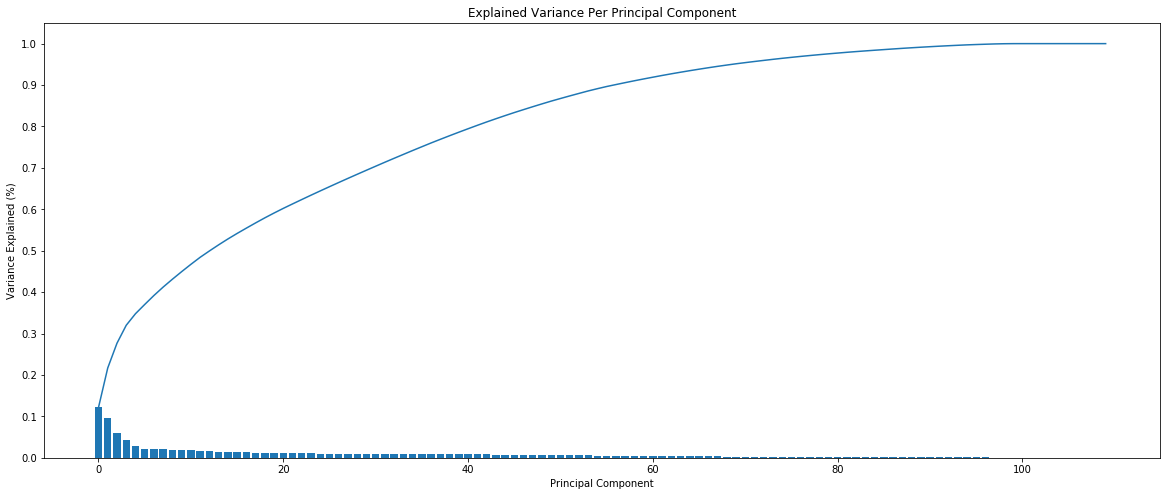

In [160]:
scree_plot(pca)

In [161]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca2 = PCA(n_components = 50)
pca2.fit(df_scaled)


PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Discussion 2.2: Perform Dimensionality Reduction

From variance graph it can be seen that 50 components can explain almost 90% of variability. So, I can use 50 components which is almost half of total columns. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [162]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_wts(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(df_scaled.columns))
    wts = df.iloc[i].sort_values(ascending=False)
    return wts


In [163]:
test = pd.DataFrame(pca.components_, columns=list(df_scaled.columns))


In [164]:
test

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['ZABEOTYP']_1,['ZABEOTYP']_2,['ZABEOTYP']_3,['ZABEOTYP']_4,['ZABEOTYP']_5,['ZABEOTYP']_6,Movement,Decade,Weathy,Life_Stage
0,-1.220434e-01,1.554572e-02,-2.184287e-01,1.537857e-01,-1.183700e-01,8.773086e-02,8.531284e-02,1.493155e-01,-1.078751e-01,3.242025e-02,...,-0.093982,-0.045463,-0.040548,0.055973,0.092866,0.034507,1.057180e-01,1.111355e-01,1.778494e-01,-1.099299e-01
1,2.227604e-01,4.610710e-02,5.289520e-02,-2.105414e-01,2.108395e-01,-1.973069e-01,-2.121618e-01,1.175336e-01,-2.630102e-02,-4.800288e-02,...,-0.079924,-0.043620,0.201550,-0.095924,-0.082428,0.028811,2.483996e-02,-2.288501e-01,8.916325e-02,-1.041125e-02
2,1.750420e-02,-3.533248e-01,1.297688e-01,-5.722789e-02,4.863431e-02,-1.586985e-01,-4.958310e-02,-6.105078e-02,7.452389e-02,-6.132227e-03,...,0.115316,-0.020100,-0.037097,-0.061657,-0.026531,0.053083,-7.184024e-02,-5.098593e-02,2.365314e-02,-1.609581e-02
3,-3.497874e-02,9.312766e-02,3.107762e-03,1.546727e-02,-2.315433e-02,-6.620047e-02,8.024438e-02,-3.787221e-02,3.438102e-01,-3.597851e-03,...,0.080698,0.091714,-0.063404,-0.016654,-0.003943,-0.030320,-3.444471e-01,3.807351e-02,-7.459895e-02,3.817650e-02
4,-9.174266e-03,-8.568419e-03,-1.443583e-01,1.298306e-02,4.503985e-02,-7.237533e-04,4.941347e-02,2.165192e-01,3.592158e-02,-6.206830e-02,...,-0.004300,-0.104042,0.052713,-0.058850,0.056509,0.020449,-4.007471e-02,-3.778309e-02,-2.106498e-02,4.095336e-02
5,1.776348e-02,-2.379418e-03,1.572430e-02,-8.181023e-03,4.900983e-02,-9.326315e-02,1.199226e-01,-9.232422e-02,-7.742848e-02,-2.553643e-02,...,-0.003265,0.036923,0.018843,-0.060349,0.009047,0.030103,7.091718e-02,-1.338246e-02,-2.863348e-02,-4.363616e-02
6,5.786488e-03,1.872331e-02,1.233456e-02,-2.139945e-02,-1.306884e-02,-1.596172e-02,-1.821329e-02,-2.081662e-02,-4.932164e-02,7.854506e-03,...,0.005974,0.079734,-0.023764,-0.011639,-0.047557,0.044976,4.877454e-02,7.393547e-03,-2.643384e-02,6.202838e-03
7,2.591286e-02,-2.862578e-02,-6.967865e-02,4.603464e-02,4.100320e-02,8.815280e-02,-4.219436e-02,8.525871e-02,1.885898e-02,1.010193e-02,...,0.048909,-0.061811,0.000481,0.055145,-0.000050,-0.104692,-2.029466e-02,-5.960668e-03,1.842136e-02,-1.173275e-02
8,4.027154e-02,2.023227e-02,-5.871883e-02,2.659963e-02,-5.136322e-02,4.949377e-02,4.524414e-02,9.014733e-02,6.604912e-02,-1.852753e-01,...,0.051128,0.046486,0.045469,-0.134130,0.092752,-0.065532,-7.766737e-02,-1.626340e-02,-3.954725e-02,5.315806e-02
9,-3.414143e-02,-1.087505e-02,3.799300e-02,-3.268077e-02,-2.052901e-02,-2.316114e-04,-1.583092e-01,-9.890764e-02,-7.522501e-03,2.024495e-01,...,-0.031745,0.067862,-0.077007,0.027429,-0.092609,0.178261,1.868433e-02,5.015379e-02,-8.532727e-03,1.097540e-02


In [165]:
test.iloc[0]

ALTERSKATEGORIE_GROB      -0.122043
ANREDE_KZ                  0.015546
FINANZ_MINIMALIST         -0.218429
FINANZ_SPARER              0.153786
FINANZ_VORSORGER          -0.118370
FINANZ_ANLEGER             0.087731
FINANZ_UNAUFFAELLIGER      0.085313
FINANZ_HAUSBAUER           0.149316
GREEN_AVANTGARDE          -0.107875
HEALTH_TYP                 0.032420
RETOURTYP_BK_S            -0.033023
SEMIO_SOZ                  0.032729
SEMIO_FAM                  0.068815
SEMIO_REL                  0.110922
SEMIO_MAT                  0.073014
SEMIO_VERT                -0.046205
SEMIO_LUST                -0.075638
SEMIO_ERL                 -0.072651
SEMIO_KULT                 0.066652
SEMIO_RAT                  0.098860
SEMIO_KRIT                 0.007165
SEMIO_DOM                  0.027484
SEMIO_KAEM                 0.039275
SEMIO_PFLICHT              0.116369
SEMIO_TRADV                0.092370
SOHO_KZ                   -0.002082
VERS_TYP                   0.021388
ANZ_PERSONEN              -0

In [166]:
pca_wts(pca2, 0)

['LP_STATUS_GROB']_1.0     0.207939
HH_EINKOMMEN_SCORE         0.187766
PLZ8_ANTG3                 0.186619
PLZ8_ANTG4                 0.180579
Weathy                     0.177849
ORTSGR_KLS9                0.160561
EWDICHTE                   0.158915
FINANZ_SPARER              0.153786
FINANZ_HAUSBAUER           0.149316
['FINANZTYP']_1            0.141786
['LP_STATUS_FEIN']_2.0     0.138080
KBA05_ANTG4                0.128900
PLZ8_ANTG2                 0.127290
['LP_STATUS_FEIN']_1.0     0.123223
KBA05_ANTG3                0.120686
SEMIO_PFLICHT              0.116369
ARBEIT                     0.116112
ANZ_HAUSHALTE_AKTIV        0.115696
Decade                     0.111135
SEMIO_REL                  0.110922
RELAT_AB                   0.109698
Movement                   0.105718
SEMIO_RAT                  0.098860
['ZABEOTYP']_5             0.092866
SEMIO_TRADV                0.092370
FINANZ_ANLEGER             0.087731
FINANZ_UNAUFFAELLIGER      0.085313
SEMIO_MAT                  0

In [167]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_wts(pca2, 1)

ALTERSKATEGORIE_GROB       0.222760
FINANZ_VORSORGER           0.210839
['ZABEOTYP']_3             0.201550
SEMIO_ERL                  0.177624
SEMIO_LUST                 0.157887
RETOURTYP_BK_S             0.157356
['LP_STATUS_FEIN']_1.0     0.125082
W_KEIT_KIND_HH             0.122448
FINANZ_HAUSBAUER           0.117534
PLZ8_ANTG3                 0.103252
['FINANZTYP']_5            0.101505
['CJT_GESAMTTYP']_2.0      0.101403
EWDICHTE                   0.099085
PLZ8_ANTG4                 0.098514
ORTSGR_KLS9                0.098235
Weathy                     0.089163
['FINANZTYP']_2            0.078262
SEMIO_KRIT                 0.077614
KBA05_ANTG4                0.075319
HH_EINKOMMEN_SCORE         0.074438
ARBEIT                     0.073622
PLZ8_ANTG2                 0.071593
ANZ_HAUSHALTE_AKTIV        0.070401
SEMIO_KAEM                 0.070348
RELAT_AB                   0.070281
['CJT_GESAMTTYP']_1.0      0.068066
['FINANZTYP']_6            0.065335
['GFK_URLAUBERTYP']_4.0    0

In [168]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_wts(pca2, 2)


SEMIO_VERT                 0.326762
SEMIO_FAM                  0.265967
SEMIO_SOZ                  0.262817
SEMIO_KULT                 0.258025
['FINANZTYP']_5            0.141606
FINANZ_MINIMALIST          0.129769
['ZABEOTYP']_1             0.115316
SEMIO_REL                  0.113638
SEMIO_MAT                  0.092499
RETOURTYP_BK_S             0.078814
GREEN_AVANTGARDE           0.074523
EWDICHTE                   0.072209
ORTSGR_KLS9                0.072171
W_KEIT_KIND_HH             0.061025
PLZ8_ANTG3                 0.057343
PLZ8_ANTG4                 0.056344
['ZABEOTYP']_6             0.053084
['LP_STATUS_GROB']_5.0     0.052891
['LP_STATUS_FEIN']_10.0    0.052891
['LP_STATUS_FEIN']_1.0     0.051686
FINANZ_VORSORGER           0.048634
['LP_STATUS_FEIN']_3.0     0.047325
PLZ8_ANTG2                 0.041930
RELAT_AB                   0.041726
ARBEIT                     0.040393
['LP_STATUS_GROB']_3.0     0.028957
['GFK_URLAUBERTYP']_4.0    0.028467
KBA05_ANTG4                0

### Discussion 2.3: Interpret Principal Components

- 1st component of PCA has a highest positive correlation with 'LP_STATUS_GROB'_1.0 which is Social status vs rough scale and has negative impact on MOBI_REGIO  and FINANZ_MINIMALIST which are Movement patterns and Financial topology (low financial interest) repectively.


- 2nd component of PCA has a highest positive correlation with ALTERSKATEGORIE_GROB and FINANZ_VORSORGER which are age range and financial topology repectively and has negative impact on Decade which indicated decade starting from 40s generation.


- 3rd component of PCA has a highest positive correlation with SEMIO_VERT which is personality topology (dreamful) and lowest negative impact on ANREDE_KZ which is gender.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [169]:
data_transformed = pca2.fit_transform(df_scaled)

Text(0.5,1,'SSE vs. K')

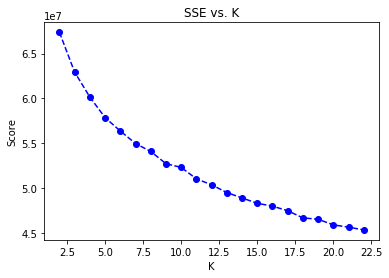

In [170]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...   
# compute the average within-cluster distances.

def get_kmeans_score(data, centers):
    kmeans_c = KMeans(n_clusters=centers)
    model = kmeans_c.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
center = list(range(2,23))
for centers in center:
    scores.append(get_kmeans_score(data_transformed, centers))
    
    
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
    
plt.plot(center, scores, linestyle='--', marker='o', color='b')
plt.xlabel("K")
plt.ylabel("Score")
plt.title("SSE vs. K")

In [171]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_c = KMeans(n_clusters=9)
model = kmeans_c.fit(data_transformed)
predicted_value = model.predict(data_transformed)

### Discussion 3.1: Apply Clustering to General Population

I have decided to use 9 number of clusters for the prediction. From the plot with centers and score it can be seen that at 9 the graph is showing the first elbow form. After the cluster 9, the line graph is not really smooth. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [181]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [182]:
customers_less_missing = clean_data(customers)

Total NaNs: 3112918


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [183]:
customers_clean = customers_less_missing.fillna(customers_less_missing.mean())

In [184]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['ZABEOTYP']_1,['ZABEOTYP']_2,['ZABEOTYP']_3,['ZABEOTYP']_4,['ZABEOTYP']_5,['ZABEOTYP']_6,Movement,Decade,Weathy,Life_Stage
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,1,0,0,0,0.0,2.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,1,0,0,0,0.0,2.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,1,0,0,0,0,0,1.0,1.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,1,0,0,0,0,0,1.0,4.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,1,0,0,0,0,0.0,2.0,3.0,4.0


In [185]:
customers_clean.isnull().sum().sum()

0

In [186]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

data_scaled = stndrd.transform(customers_clean)
customers_scaled = pd.DataFrame(data_scaled, columns = customers_clean.columns.tolist())
customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,['ZABEOTYP']_1,['ZABEOTYP']_2,['ZABEOTYP']_3,['ZABEOTYP']_4,['ZABEOTYP']_5,['ZABEOTYP']_6,Movement,Decade,Weathy,Life_Stage
0,1.184837,-1.043765,1.409069,-1.155304,1.137960,-1.249881,-0.469752,-0.792034,1.884775,-1.625569,...,-0.427707,-0.207652,1.352118,-0.592927,-0.336084,-0.312245,-1.874931,-1.629389,-1.550709,0.085880
1,1.184837,0.958071,1.409069,-1.155304,1.137960,-1.249881,0.959677,0.628533,1.884775,-0.270002,...,-0.427707,-0.207652,1.352118,-0.592927,-0.336084,-0.312245,-1.874931,-1.629389,-0.179899,0.761893
2,1.184837,-1.043765,1.409069,-1.155304,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.270002,...,2.338049,-0.207652,-0.739580,-0.592927,-0.336084,-0.312245,0.553091,-2.328113,-0.865304,0.761893
3,0.201306,-1.043765,-0.042770,-1.155304,0.411731,0.787366,1.674391,-0.792034,-0.530567,1.085565,...,2.338049,-0.207652,-0.739580,-0.592927,-0.336084,-0.312245,0.553091,-0.231940,0.505507,-1.266147
4,0.201306,-1.043765,1.409069,-1.155304,1.137960,-1.249881,-0.469752,-0.081750,1.884775,1.085565,...,-0.427707,4.815760,-0.739580,-0.592927,-0.336084,-0.312245,-1.874931,-1.629389,-0.179899,0.761893


In [187]:
customers_transformed = pca2.transform(customers_scaled)

In [188]:
predicted_customers = model.predict(customers_transformed)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [189]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def cluster_comparison(general,customers):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('General Clusters')
    sns.countplot(general,ax=ax1)

    ax2.set_title('Customers Clusters')
    sns.countplot(customers,ax=ax2)
    plt.show()


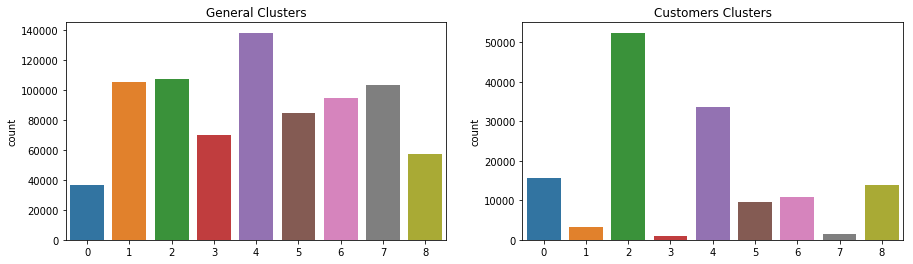

In [190]:
cluster_comparison(predicted_value, predicted_customers)

In [191]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_2 = stndrd.inverse_transform(pca2.inverse_transform(model.cluster_centers_[2]))


In [192]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_7 = stndrd.inverse_transform(pca2.inverse_transform(model.cluster_centers_[7]))

In [193]:
cluster_df = pd.DataFrame({"features":customers_scaled.columns,"Overrepresented":cluster_2,"Underrepresented":cluster_7})

In [194]:
cluster_df

,features,Overrepresented,Underrepresented
0,ALTERSKATEGORIE_GROB,3.176225,1.808076
1,ANREDE_KZ,1.477636,1.990530
2,FINANZ_MINIMALIST,4.519251,1.098769
3,FINANZ_SPARER,1.877216,4.462313
4,FINANZ_VORSORGER,3.945440,2.227258
5,FINANZ_ANLEGER,2.016466,4.422761
6,FINANZ_UNAUFFAELLIGER,2.371205,3.864130
7,FINANZ_HAUSBAUER,1.909114,4.318658
8,GREEN_AVANTGARDE,1.001872,0.041295
9,HEALTH_TYP,2.128490,2.207216


In [195]:
cluster_df[(cluster_df['Overrepresented'] >=4)][['features', 'Overrepresented']].sort_values('Overrepresented', ascending=False)

,features,Overrepresented
35,MIN_GEBAEUDEJAHR,1993.406821
50,KBA13_ANZAHL_PKW,694.721891
31,WOHNDAUER_2008,8.535831
58,ORTSGR_KLS9,5.161190
16,SEMIO_LUST,4.948473
17,SEMIO_ERL,4.928705
44,INNENSTADT,4.779252
15,SEMIO_VERT,4.751115
21,SEMIO_DOM,4.628628
2,FINANZ_MINIMALIST,4.519251


In [196]:
cluster_df[(cluster_df['Underrepresented'] > 4)][['features', 'Underrepresented']].sort_values('Underrepresented', ascending=False)

,features,Underrepresented
35,MIN_GEBAEUDEJAHR,1992.628973
50,KBA13_ANZAHL_PKW,561.156423
32,ANZ_HAUSHALTE_AKTIV,13.765074
31,WOHNDAUER_2008,7.238637
58,ORTSGR_KLS9,6.586517
21,SEMIO_DOM,6.028067
22,SEMIO_KAEM,6.016304
23,SEMIO_PFLICHT,6.012639
19,SEMIO_RAT,5.946588
107,Decade,5.588780


### Discussion 3.3: Compare Customer Data to Demographics Data

- Cluster 2 is overrepresented in customer data.The features associated with cluster 2 are listed below. The ordered list is listed from highest to lowest to show correlation with the given cluster.
  1. WOHNDAUER_2008: length of residence
  * SEMIO_LUST: Personality typology and Dimension translations (sensual-minded)
  * SEMIO_ERL: Personality typology and Dimension translations (event-oriented)
  * INNENSTADT: Distance to city center (downtown)
  * SEMIO_VERT: Personality typology and Dimension translations (dreamful)
  * SEMIO_DOM: Personality typology and Dimension translations (dominant-minded)
  * FINANZ_MINIMALIST: Financial typology and Dimension translations (low financial interest)
 
 

- Cluster 7 is underrepresented in customer data. The features associated with cluster 7 are listed below. The ordered list is listed from highest to lowest to show correlation with the given cluster.
  1. ANZ_HAUSHALTE_AKTIV: Number of households in the building
  2. WOHNDAUER_2008: length of residence
  3. SEMIO_DOM: Personality typology and Dimension translations (dominant-minded)
  4. SEMIO_KAEM: Personality typology and Dimension translations (combative attitude)
  3. SEMIO_PFLICHT: Personality typology and Dimension translations (dutiful)
  4. SEMIO_RAT: Personality typology and Dimension translations (rational)
  5. Decade: Generation
  6. HH_EINKOMMEN_SCORE: Estimated household net income
  7. SEMIO_KRIT: Personality typology and Dimension translations (critical-minded)
  8. SEMIO_TRADV: Personality typology and Dimension translations (tradional-minded)
  9. SEMIO_REL: Personality typology and Dimension translations (religious)



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.